<a href="https://colab.research.google.com/github/aaaaaamah99/Computer_Vision/blob/main/Computer_Vision/Week_1/CVTask_1_Skin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Medical Imaging Data Using Super Gradients**
# Arsitektur YOLO-NAS S


#Install Python Package

In [1]:
!pip install boto3 deprecated coverage sphinx-rtd-theme torchmetrics hydra-core omegaconf onnxruntime onnx einops treelib stringcase rapidfuzz json-tricks onnx-simplifier data-gradients
!pip show boto3 deprecated coverage sphinx-rtd-theme torchmetrics hydra-core omegaconf onnxruntime onnx einops treelib stringcase rapidfuzz json-tricks onnx-simplifier data-gradients


Name: boto3
Version: 1.34.32
Summary: The AWS SDK for Python
Home-page: https://github.com/boto/boto3
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: botocore, jmespath, s3transfer
Required-by: super-gradients
---
Name: Deprecated
Version: 1.2.14
Summary: Python @deprecated decorator to deprecate old python classes, functions or methods.
Home-page: https://github.com/tantale/deprecated
Author: Laurent LAPORTE
Author-email: tantale.solutions@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: wrapt
Required-by: super-gradients
---
Name: coverage
Version: 5.3.1
Summary: Code coverage measurement for Python
Home-page: https://github.com/nedbat/coveragepy
Author: Ned Batchelder and 138 others
Author-email: ned@nedbatchelder.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: data-gradients, super-gradients
---
Name: sphinx-rtd-theme

In [2]:
!pip install --upgrade numpy
!pip install fastapi kaleido python-multipart uvicorn


  Using cached numpy-1.26.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
super-gradients 3.5.0 requires numpy<=1.23, but you have numpy 1.26.3 which is incompatible.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


#Install SuperGradient

In [3]:
! pip install -qq super-gradients==3.5.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.0 which is incompatible.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


#Experiment Setup

#Import Dataloader

In [63]:
from super_gradients import Trainer

experiment_name = "classification_transfer_learning"
model_name = "resnet18"

CHECKPOINT_DIR = '/home/notebook_ckpts/'
trainer = Trainer(experiment_name=experiment_name, ckpt_root_dir=CHECKPOINT_DIR)

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8Q4Z4axUIjr8Kb9cHz4O")
project = rf.workspace("sdd-uicay").project("skin-detection-abrez")
dataset = project.version(6).download("clip")


loading Roboflow workspace...
loading Roboflow project...


In [64]:
from super_gradients.training.dataloaders import your_custom_dataloader_function

# Specify dataset and dataloader parameters
dataset_params = {}
dataloader_params = {"num_workers": 2}

# Replace the following with your custom dataloader function
def custom_skin_cancer_dataloader(dataset_path, dataset_params, dataloader_params):
    # Implement logic to load your skin cancer dataset
    # You may need to create a custom dataset class or use existing classes

    # Example: Assuming you have a function `load_skin_cancer_dataset` to load your dataset
    skin_cancer_dataset = load_skin_cancer_dataset(dataset_path, **dataset_params)

    # Use the custom dataloader function from the library
    dataloader = your_custom_dataloader_function(skin_cancer_dataset, **dataloader_params)

    return dataloader

# Specify the custom dataset paths
skin_cancer_train_dataset_name = "/content/Skin-Detection-6/train"
skin_cancer_valid_dataset_name = "/content/Skin-Detection-6/valid"

# Get the custom dataloaders
train_dataloader = custom_skin_cancer_dataloader(skin_cancer_train_dataset_name, dataset_params, dataloader_params)
valid_dataloader = custom_skin_cancer_dataloader(skin_cancer_valid_dataset_name, dataset_params, dataloader_params)


ImportError: cannot import name 'your_custom_dataloader_function' from 'super_gradients.training.dataloaders' (/usr/local/lib/python3.10/dist-packages/super_gradients/training/dataloaders/__init__.py)

In [65]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Specify the path to your lung cancer dataset
dataset_path = "/content/Skin-Detection-6"  # Replace with the actual path

# Define dataset and dataloader parameters
dataset_params = {
    "root": dataset_path,
    "transform": transforms.ToTensor(),  # Adjust the transformation as needed
}

dataloader_params = {
    "batch_size": 32,
    "shuffle": True,
    "num_workers": 2,
    # ... other dataloader parameters ...
}

# Load lung cancer training dataset
train_dataset = ImageFolder(root="/content/Skin-Detection-6/train", transform=dataset_params["transform"])
train_dataloader = DataLoader(train_dataset, **dataloader_params)

# Load lung cancer validation dataset
valid_dataset = ImageFolder(root="/content/Skin-Detection-6/valid", transform=dataset_params["transform"])
valid_dataloader = DataLoader(valid_dataset, **dataloader_params)


In [66]:
import pprint

# Print dataloader parameters
print("Dataloader parameters:")
pprint.pprint({
    "batch_size": train_dataloader.batch_size,
    #"shuffle": train_dataloader.shuffle,
    "num_workers": train_dataloader.num_workers,
    # ... other dataloader parameters ...
})

# Print dataset parameters
print("\nDataset parameters:")
pprint.pprint({
    "root": train_dataloader.dataset.root,
    "transform": train_dataloader.dataset.transform,
    # ... other dataset parameters ...
})


Dataloader parameters:
{'batch_size': 32, 'num_workers': 2}

Dataset parameters:
{'root': '/content/Skin-Detection-6/train', 'transform': ToTensor()}


In [67]:
from matplotlib import pyplot as plt

def show(images, labels, classes, rows=6, columns=5):
  fig = plt.figure(figsize=(10, 10))

  for i in range(1, columns * rows + 1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[i-1].permute(1, 2, 0).clamp(0, 1))
      plt.xticks([])
      plt.yticks([])
      plt.title(f"{classes[labels[i-1]]}")

torch.Size([32, 3, 224, 224]) torch.Size([32])


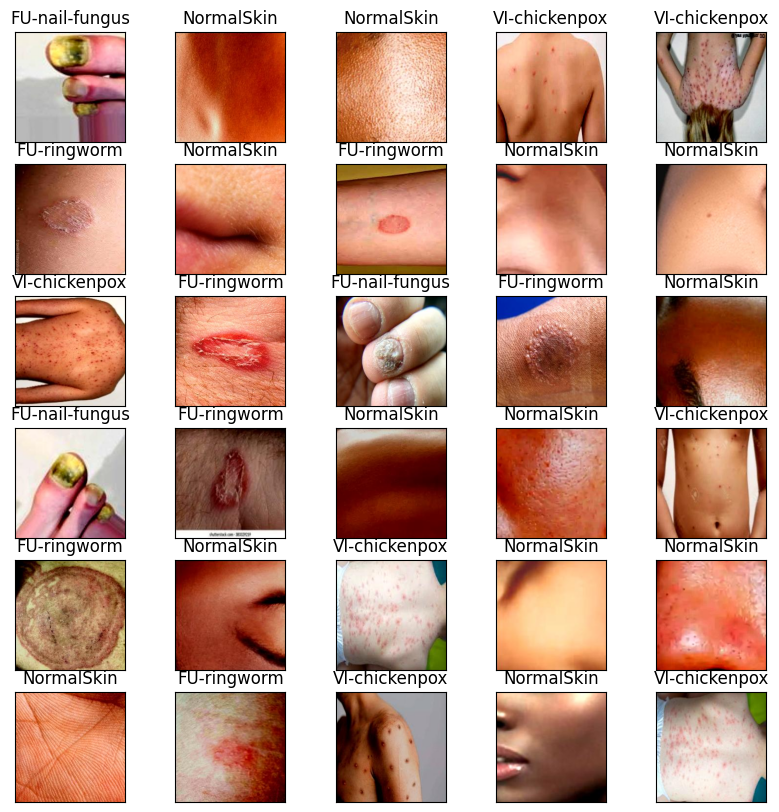

In [68]:
vis_images_train, vis_labels_train = next(iter(train_dataloader))
show(vis_images_train, vis_labels_train, classes=train_dataloader.dataset.classes)

print(vis_images_train.shape, vis_labels_train.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


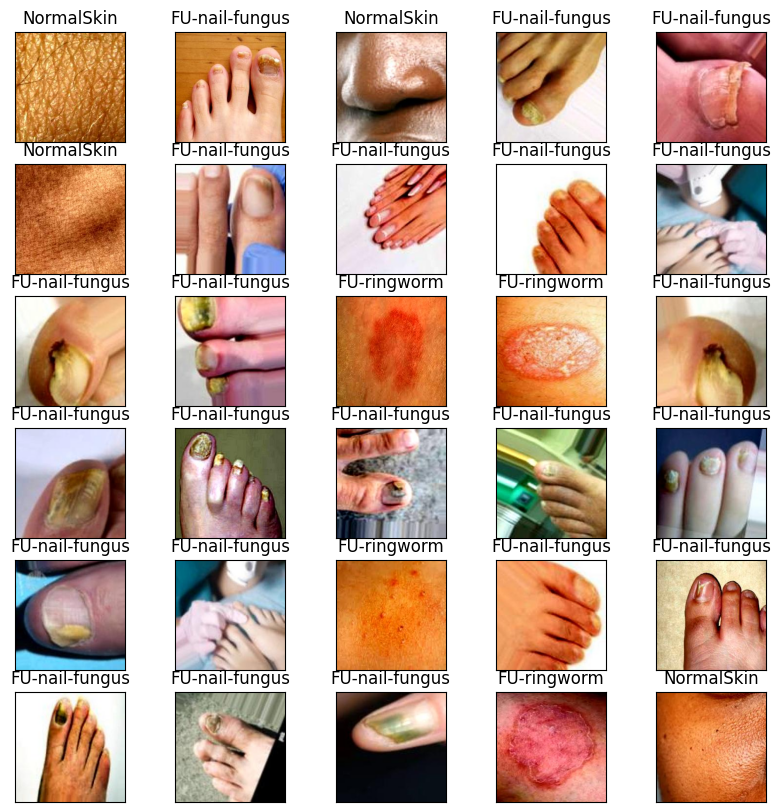

In [69]:
vis_images_val, vis_labels_val = next(iter(valid_dataloader))
show(vis_images_val, vis_labels_val, classes=train_dataloader.dataset.classes)

print(vis_images_val.shape, vis_labels_val.shape)

#Overide Parameters

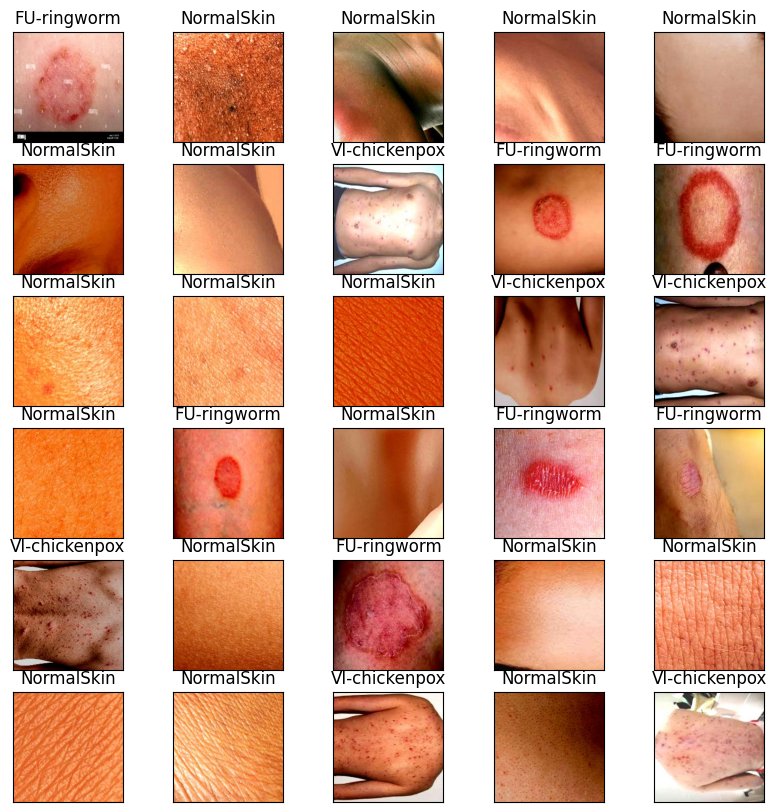

In [70]:
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

# Specify the path to your skin cancer dataset
dataset_path = "/content/Skin-Detection-6"  # Replace with the actual path

# Define dataset and dataloader parameters
transforms_vis = T.Compose([T.ToTensor()])  # Your custom transformations

# Create a custom dataset class
class CustomSkinCancerDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root="/content/Skin-Detection-6/train", transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

# Instantiate your custom dataset
custom_skin_cancer_dataset = CustomSkinCancerDataset(root=dataset_path, transform=transforms_vis)

# Define dataloader parameters
dataloader_params = {
    "batch_size": 32,
    "shuffle": True,
    "num_workers": 2,
    # ... other dataloader parameters ...
}

# Create a DataLoader for your custom dataset
custom_skin_cancer_dataloader = DataLoader(custom_skin_cancer_dataset, **dataloader_params)

# Assuming you have a show function defined, show the images and labels
custom_skin_cancer_images, custom_skin_cancer_labels = next(iter(custom_skin_cancer_dataloader))
show(custom_skin_cancer_images, custom_skin_cancer_labels, classes=custom_skin_cancer_dataset.dataset.classes)


#Architecture = Resnet18

In [122]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(model_name=Models.RESNET18, num_classes=10, pretrained_weights="imagenet")

#Training

In [73]:
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams
# you can see more recipes in super_gradients/recipes
training_params =  training_hyperparams.get("training_hyperparams/cifar10_resnet_train_params")

In 'training_hyperparams/cifar10_resnet_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information


In [74]:
pprint.pprint("Training parameters")
pprint.pprint(training_params)

In [75]:
training_params["max_epochs"] = 15

In [77]:
trainer.train(model=model,
              training_params=training_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2024-02-01 15:00:49] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2024-02-01 15:00:49] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240201_150049_677125`
[2024-02-01 15:00:49] INFO - sg_trainer.py - Checkpoints directory: /home/notebook_ckpts/classification_transfer_learning/RUN_20240201_150049_677125


The console stream is now moved to /home/notebook_ckpts/classification_transfer_learning/RUN_20240201_150049_677125/console_Feb01_15_00_49.txt


[2024-02-01 15:00:50] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            1467       (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         46         (len(train_loader))
    - Gradient updates per epoch:   46         (len(train_loader) / batch_accumulate)
    - Model: ResNet18  (11.18M parameters, 11.18M optimized)
    - Learning Rates and Weight Decays:
      - default: (11.18M parameters). LR: 0.1 (11.18M parameters) WD: 0.0001, (11.18M parameters)

[2024-02-01 15:00:50] INFO - sg_trainer.py - Started training for 250 epochs (0/249)

Train epoch 0: 

In [76]:
train_params_path = "training_hyperparams/cifar10_resnet_train_params"
training_params = training_hyperparams.get(train_params_path)


In [78]:
import torch
import torchvision.models as models

# Instantiate ResNet18
model = models.resnet18()

# Other model configurations or modifications can be done based on your requirements


In [81]:
trainer = Trainer(experiment_name="skin", ckpt_root_dir="/content/Skin-Detection-6/train")
training_params["max_epochs"] = 15
trainer.train(model=model, training_params=training_params, train_loader=train_dataloader, valid_loader=valid_dataloader)


[2024-02-01 15:08:19] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2024-02-01 15:08:19] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240201_150819_252323`
[2024-02-01 15:08:19] INFO - sg_trainer.py - Checkpoints directory: /content/Skin-Detection-6/train/skin/RUN_20240201_150819_252323


The console stream is now moved to /content/Skin-Detection-6/train/skin/RUN_20240201_150819_252323/console_Feb01_15_08_19.txt


[2024-02-01 15:08:19] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            1467       (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         46         (len(train_loader))
    - Gradient updates per epoch:   46         (len(train_loader) / batch_accumulate)
    - Model: ResNet  (11.69M parameters, 11.69M optimized)
    - Learning Rates and Weight Decays:
      - default: (11.69M parameters). LR: 0.1 (11.69M parameters) WD: 0.0001, (11.69M parameters)

[2024-02-01 15:08:19] INFO - sg_trainer.py - Started training for 15 epochs (0/14)

Validating: 100%|██

SUMMARY OF EPOCH 0
├── Train
│   ├── Labelsmoothingcrossentropyloss = 2.9531
│   ├── Accuracy = 0.4383
│   └── Top5 = 0.9659
└── Validation
    ├── Labelsmoothingcrossentropyloss = 3.3167
    ├── Accuracy = 0.0882
    └── Top5 = 1.0



Validating epoch 1: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
[2024-02-01 15:21:09] INFO - base_sg_logger.py - Checkpoint saved in /content/Skin-Detection-6/train/skin/RUN_20240201_150819_252323/ckpt_best.pth
[2024-02-01 15:21:09] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.3235294222831726


SUMMARY OF EPOCH 1
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.0012
│   │   ├── Epoch N-1      = 2.9531 (↘ -1.9519)
│   │   └── Best until now = 2.9531 (↘ -1.9519)
│   ├── Accuracy = 0.6074
│   │   ├── Epoch N-1      = 0.4383 (↗ 0.1691)
│   │   └── Best until now = 0.4383 (↗ 0.1691)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 0.9659 (↗ 0.0341)
│       └── Best until now = 0.9659 (↗ 0.0341)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.7955
    │   ├── Epoch N-1      = 3.3167 (↘ -1.5212)
    │   └── Best until now = 3.3167 (↘ -1.5212)
    ├── Accuracy = 0.3235
    │   ├── Epoch N-1      = 0.0882 (↗ 0.2353)
    │   └── Best until now = 0.0882 (↗ 0.2353)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 2: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


SUMMARY OF EPOCH 2
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.9378
│   │   ├── Epoch N-1      = 1.0012 (↘ -0.0634)
│   │   └── Best until now = 1.0012 (↘ -0.0634)
│   ├── Accuracy = 0.6108
│   │   ├── Epoch N-1      = 0.6074 (↗ 0.0034)
│   │   └── Best until now = 0.6074 (↗ 0.0034)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.2784
    │   ├── Epoch N-1      = 1.7955 (↘ -0.5171)
    │   └── Best until now = 1.7955 (↘ -0.5171)
    ├── Accuracy = 0.2941
    │   ├── Epoch N-1      = 0.3235 (↘ -0.0294)
    │   └── Best until now = 0.3235 (↘ -0.0294)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 3: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


SUMMARY OF EPOCH 3
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.8828
│   │   ├── Epoch N-1      = 0.9378 (↘ -0.055)
│   │   └── Best until now = 0.9378 (↘ -0.055)
│   ├── Accuracy = 0.6217
│   │   ├── Epoch N-1      = 0.6108 (↗ 0.0109)
│   │   └── Best until now = 0.6108 (↗ 0.0109)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 2.8813
    │   ├── Epoch N-1      = 1.2784 (↗ 1.6029)
    │   └── Best until now = 1.2784 (↗ 1.6029)
    ├── Accuracy = 0.0588
    │   ├── Epoch N-1      = 0.2941 (↘ -0.2353)
    │   └── Best until now = 0.3235 (↘ -0.2647)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 4: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


SUMMARY OF EPOCH 4
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.8559
│   │   ├── Epoch N-1      = 0.8828 (↘ -0.0269)
│   │   └── Best until now = 0.8828 (↘ -0.0269)
│   ├── Accuracy = 0.6599
│   │   ├── Epoch N-1      = 0.6217 (↗ 0.0382)
│   │   └── Best until now = 0.6217 (↗ 0.0382)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.7805
    │   ├── Epoch N-1      = 2.8813 (↘ -1.1008)
    │   └── Best until now = 1.2784 (↗ 0.5021)
    ├── Accuracy = 0.1765
    │   ├── Epoch N-1      = 0.0588 (↗ 0.1176)
    │   └── Best until now = 0.3235 (↘ -0.1471)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 5: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


SUMMARY OF EPOCH 5
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.738
│   │   ├── Epoch N-1      = 0.8559 (↘ -0.1179)
│   │   └── Best until now = 0.8559 (↘ -0.1179)
│   ├── Accuracy = 0.6796
│   │   ├── Epoch N-1      = 0.6599 (↗ 0.0198)
│   │   └── Best until now = 0.6599 (↗ 0.0198)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 2.299
    │   ├── Epoch N-1      = 1.7805 (↗ 0.5184)
    │   └── Best until now = 1.2784 (↗ 1.0206)
    ├── Accuracy = 0.2647
    │   ├── Epoch N-1      = 0.1765 (↗ 0.0882)
    │   └── Best until now = 0.3235 (↘ -0.0588)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 6: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]
[2024-02-01 15:52:35] INFO - base_sg_logger.py - Checkpoint saved in /content/Skin-Detection-6/train/skin/RUN_20240201_150819_252323/ckpt_best.pth
[2024-02-01 15:52:35] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5808823704719543


SUMMARY OF EPOCH 6
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.7197
│   │   ├── Epoch N-1      = 0.738  (↘ -0.0183)
│   │   └── Best until now = 0.738  (↘ -0.0183)
│   ├── Accuracy = 0.7144
│   │   ├── Epoch N-1      = 0.6796 (↗ 0.0348)
│   │   └── Best until now = 0.6796 (↗ 0.0348)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.1335
    │   ├── Epoch N-1      = 2.299  (↘ -1.1655)
    │   └── Best until now = 1.2784 (↘ -0.1449)
    ├── Accuracy = 0.5809
    │   ├── Epoch N-1      = 0.2647 (↗ 0.3162)
    │   └── Best until now = 0.3235 (↗ 0.2574)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 7: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


SUMMARY OF EPOCH 7
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.6761
│   │   ├── Epoch N-1      = 0.7197 (↘ -0.0436)
│   │   └── Best until now = 0.7197 (↘ -0.0436)
│   ├── Accuracy = 0.7212
│   │   ├── Epoch N-1      = 0.7144 (↗ 0.0068)
│   │   └── Best until now = 0.7144 (↗ 0.0068)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 2.1531
    │   ├── Epoch N-1      = 1.1335 (↗ 1.0196)
    │   └── Best until now = 1.1335 (↗ 1.0196)
    ├── Accuracy = 0.2059
    │   ├── Epoch N-1      = 0.5809 (↘ -0.375)
    │   └── Best until now = 0.5809 (↘ -0.375)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 8: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]
[2024-02-01 16:05:05] INFO - base_sg_logger.py - Checkpoint saved in /content/Skin-Detection-6/train/skin/RUN_20240201_150819_252323/ckpt_best.pth
[2024-02-01 16:05:05] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.720588207244873


SUMMARY OF EPOCH 8
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.6154
│   │   ├── Epoch N-1      = 0.6761 (↘ -0.0607)
│   │   └── Best until now = 0.6761 (↘ -0.0607)
│   ├── Accuracy = 0.7566
│   │   ├── Epoch N-1      = 0.7212 (↗ 0.0354)
│   │   └── Best until now = 0.7212 (↗ 0.0354)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.8625
    │   ├── Epoch N-1      = 2.1531 (↘ -1.2906)
    │   └── Best until now = 1.1335 (↘ -0.271)
    ├── Accuracy = 0.7206
    │   ├── Epoch N-1      = 0.2059 (↗ 0.5147)
    │   └── Best until now = 0.5809 (↗ 0.1397)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 9: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.6422
│   │   ├── Epoch N-1      = 0.6154 (↗ 0.0267)
│   │   └── Best until now = 0.6154 (↗ 0.0267)
│   ├── Accuracy = 0.728
│   │   ├── Epoch N-1      = 0.7566 (↘ -0.0286)
│   │   └── Best until now = 0.7566 (↘ -0.0286)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.1911
    │   ├── Epoch N-1      = 0.8625 (↗ 0.3286)
    │   └── Best until now = 0.8625 (↗ 0.3286)
    ├── Accuracy = 0.5809
    │   ├── Epoch N-1      = 0.7206 (↘ -0.1397)
    │   └── Best until now = 0.7206 (↘ -0.1397)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 10: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


SUMMARY OF EPOCH 10
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.5136
│   │   ├── Epoch N-1      = 0.6422 (↘ -0.1285)
│   │   └── Best until now = 0.6154 (↘ -0.1018)
│   ├── Accuracy = 0.803
│   │   ├── Epoch N-1      = 0.728  (↗ 0.075)
│   │   └── Best until now = 0.7566 (↗ 0.0464)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.9527
    │   ├── Epoch N-1      = 1.1911 (↗ 0.7615)
    │   └── Best until now = 0.8625 (↗ 1.0902)
    ├── Accuracy = 0.4118
    │   ├── Epoch N-1      = 0.5809 (↘ -0.1691)
    │   └── Best until now = 0.7206 (↘ -0.3088)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 11: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
[2024-02-01 16:23:57] INFO - base_sg_logger.py - Checkpoint saved in /content/Skin-Detection-6/train/skin/RUN_20240201_150819_252323/ckpt_best.pth
[2024-02-01 16:23:57] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.7867646813392639


SUMMARY OF EPOCH 11
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.4696
│   │   ├── Epoch N-1      = 0.5136 (↘ -0.044)
│   │   └── Best until now = 0.5136 (↘ -0.044)
│   ├── Accuracy = 0.8187
│   │   ├── Epoch N-1      = 0.803  (↗ 0.0157)
│   │   └── Best until now = 0.803  (↗ 0.0157)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.7312
    │   ├── Epoch N-1      = 1.9527 (↘ -1.2215)
    │   └── Best until now = 0.8625 (↘ -0.1313)
    ├── Accuracy = 0.7868
    │   ├── Epoch N-1      = 0.4118 (↗ 0.375)
    │   └── Best until now = 0.7206 (↗ 0.0662)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 12: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


SUMMARY OF EPOCH 12
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.4506
│   │   ├── Epoch N-1      = 0.4696 (↘ -0.019)
│   │   └── Best until now = 0.4696 (↘ -0.019)
│   ├── Accuracy = 0.833
│   │   ├── Epoch N-1      = 0.8187 (↗ 0.0143)
│   │   └── Best until now = 0.8187 (↗ 0.0143)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.7963
    │   ├── Epoch N-1      = 0.7312 (↗ 1.0652)
    │   └── Best until now = 0.7312 (↗ 1.0652)
    ├── Accuracy = 0.4191
    │   ├── Epoch N-1      = 0.7868 (↘ -0.3676)
    │   └── Best until now = 0.7868 (↘ -0.3676)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 13: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


SUMMARY OF EPOCH 13
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.4277
│   │   ├── Epoch N-1      = 0.4506 (↘ -0.023)
│   │   └── Best until now = 0.4506 (↘ -0.023)
│   ├── Accuracy = 0.8364
│   │   ├── Epoch N-1      = 0.833  (↗ 0.0034)
│   │   └── Best until now = 0.833  (↗ 0.0034)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.9263
    │   ├── Epoch N-1      = 1.7963 (↘ -0.8701)
    │   └── Best until now = 0.7312 (↗ 0.1951)
    ├── Accuracy = 0.7132
    │   ├── Epoch N-1      = 0.4191 (↗ 0.2941)
    │   └── Best until now = 0.7868 (↘ -0.0735)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



Validating epoch 14: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


SUMMARY OF EPOCH 14
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.4009
│   │   ├── Epoch N-1      = 0.4277 (↘ -0.0268)
│   │   └── Best until now = 0.4277 (↘ -0.0268)
│   ├── Accuracy = 0.8582
│   │   ├── Epoch N-1      = 0.8364 (↗ 0.0218)
│   │   └── Best until now = 0.8364 (↗ 0.0218)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (= 0.0)
│       └── Best until now = 1.0    (= 0.0)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.153
    │   ├── Epoch N-1      = 0.9263 (↗ 0.2267)
    │   └── Best until now = 0.7312 (↗ 0.4218)
    ├── Accuracy = 0.6691
    │   ├── Epoch N-1      = 0.7132 (↘ -0.0441)
    │   └── Best until now = 0.7868 (↘ -0.1176)
    └── Top5 = 1.0
        ├── Epoch N-1      = 1.0    (= 0.0)
        └── Best until now = 1.0    (= 0.0)



[2024-02-01 16:42:53] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


#Predict

In [116]:
from torchvision.models import resnet18

# Define the ResNet18 model with the correct number of classes
num_classes = 10  # Replace with the actual number of classes
best_model = resnet18(pretrained=False, num_classes=num_classes)

# Load the weights from the checkpoint
checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")
checkpoint = torch.load(checkpoint_path)

# Load the model's state_dict from the 'net' key
model_state_dict_key = 'net'
model_state_dict = checkpoint[model_state_dict_key]

# Update the final fully connected layer to match the number of classes in your dataset
# Assuming the name of the final layer is 'fc', modify this line accordingly if it's different
model_state_dict['fc.weight'] = model_state_dict['fc.weight'][:num_classes, :]
model_state_dict['fc.bias'] = model_state_dict['fc.bias'][:num_classes]

# Load the modified state_dict into the model
best_model.load_state_dict(model_state_dict)
best_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [117]:
# Update the final fully connected layer to match the number of classes in your dataset
model_state_dict['fc.weight'] = model_state_dict['fc.weight'][:num_classes, :]
model_state_dict['fc.bias'] = model_state_dict['fc.bias'][:num_classes]


In [118]:
from torchvision.models import resnet18

# Define the ResNet18 model with the correct number of classes
num_classes = 10  # Replace with the actual number of classes
best_model = resnet18(pretrained=False, num_classes=num_classes)

# Load the weights from the checkpoint
checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")
checkpoint = torch.load(checkpoint_path)

# Load the model's state_dict from the 'net' key
model_state_dict_key = 'net'
model_state_dict = checkpoint[model_state_dict_key]

# Update the final fully connected layer to match the number of classes in your dataset
model_state_dict['fc.weight'] = model_state_dict['fc.weight'][:num_classes, :]
model_state_dict['fc.bias'] = model_state_dict['fc.bias'][:num_classes]

# Load the modified state_dict into the model
best_model.load_state_dict(model_state_dict)
best_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [128]:
import torchvision.models as models
import inspect

# Load ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Inspect the source code
source_code = inspect.getsource(resnet18.__class__)
print(source_code)


Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
 76%|███████▋  | 34.1M/44.7M [00:00<00:00, 122MB/s]

In [130]:
from PIL import Image
import os
import torch
from torchvision.models import resnet18
from super_gradients.training.processing.processing import ComposeProcessing, NormalizeImage, Resize, StandardizeImage, ImagePermute

# Load the best model that we trained
best_model = resnet18(pretrained=False, num_classes=10)  # Adjust num_classes based on your actual number of classes
best_model.eval()

# Load the weights from the checkpoint
checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")
checkpoint = torch.load(checkpoint_path)

# Load the model's state_dict from the 'net' key
model_state_dict_key = 'net'
model_state_dict = checkpoint[model_state_dict_key]

# Update the final fully connected layer to match the number of classes in your dataset
# Assuming the name of the final layer is 'fc', modify this line accordingly if it's different
model_state_dict['fc.weight'] = model_state_dict['fc.weight'][:num_classes, :]
model_state_dict['fc.bias'] = model_state_dict['fc.bias'][:num_classes]

# Load the modified state_dict into the model
best_model.load_state_dict(model_state_dict)
best_model.eval()

# Define image processing pipeline
image_processor = ComposeProcessing([
    Resize(size=64),
    StandardizeImage(),
    NormalizeImage(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ImagePermute()
])

# Set dataset processing parameters
classes = train_dataloader.dataset.classes
best_model.set_dataset_processing_params(image_processor=image_processor, class_names=classes)

# Make predictions on a test image
image_path = "/content/Skin-Detection-6/test/FU-nail-fungus/Image_21_jpg.rf.91dc9e5b8934431f93d932b4aee2cb32.jpg"
prediction = best_model.predict(image_path)

# Display the prediction
prediction.show()


AttributeError: 'ResNet' object has no attribute 'set_dataset_processing_params'

In [131]:
from PIL import Image
import os
import torch
from torchvision.models import resnet18
from super_gradients.training.processing.processing import ComposeProcessing, NormalizeImage, Resize, StandardizeImage, ImagePermute

# Load the best model that we trained
best_model = resnet18(pretrained=False, num_classes=10)  # Adjust num_classes based on your actual number of classes
best_model.eval()

# Load the weights from the checkpoint
checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")
checkpoint = torch.load(checkpoint_path)

# Load the model's state_dict from the 'net' key
model_state_dict_key = 'net'
model_state_dict = checkpoint[model_state_dict_key]

# Update the final fully connected layer to match the number of classes in your dataset
# Assuming the name of the final layer is 'fc', modify this line accordingly if it's different
model_state_dict['fc.weight'] = model_state_dict['fc.weight'][:num_classes, :]
model_state_dict['fc.bias'] = model_state_dict['fc.bias'][:num_classes]

# Load the modified state_dict into the model
best_model.load_state_dict(model_state_dict)
best_model.eval()

# Define image processing pipeline
image_processor = ComposeProcessing([
    Resize(size=64),
    StandardizeImage(),
    NormalizeImage(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ImagePermute()
])

# Make predictions on a test image
image_path = "/content/Skin-Detection-6/test/FU-nail-fungus/Image_21_jpg.rf.91dc9e5b8934431f93d932b4aee2cb32.jpg"
processed_image = image_processor(Image.open(image_path).convert("RGB"))

# Apply the processed image to the model
with torch.no_grad():
    prediction = best_model(processed_image.unsqueeze(0))

# Display the prediction
prediction.show()


TypeError: 'ComposeProcessing' object is not callable

In [120]:
from PIL import Image
import os
import torch
from super_gradients.training.processing.processing import ComposeProcessing, NormalizeImage, Resize, StandardizeImage, ImagePermute

# Assuming you have trained a ResNet18 model and saved its checkpoints
checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")

# Load the best model that you trained
best_model = models.get(models.RESNET18, num_classes=10, checkpoint_path=checkpoint_path)
best_model.eval()

# Define image processing pipeline
image_processor = ComposeProcessing([
    Resize(size=64),
    StandardizeImage(),
    NormalizeImage(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ImagePermute()
])

# Set dataset processing parameters
classes = train_dataloader.dataset.classes
best_model.set_dataset_processing_params(image_processor=image_processor, class_names=classes)

# Make predictions on a test image
image_path = "/content/Skin-Detection-6/test/FU-nail-fungus/Image_21_jpg.rf.91dc9e5b8934431f93d932b4aee2cb32.jpg"
prediction = best_model.predict(image_path)

# Display the prediction
prediction.show()


AttributeError: module 'super_gradients.training.models' has no attribute 'RESNET18'

#Convert to ONNX

In [ ]:
import torch
onnx_filename = f"{experiment_name}_{model_name}.onnx"

best_model.eval()
best_model.prep_model_for_conversion(input_size=[1, 3, 32, 32]) # image shape of CIFAR10 images
dummy_input = torch.randn([1, 3, 32, 32], device=next(best_model.parameters()).device)

torch.onnx.export(best_model, dummy_input, onnx_filename)

Train epoch 43:   0%|          | 0/4 [00:05<?, ?it/s]
[2024-01-26 03:27:22] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2024-01-26 03:27:22] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2024-01-26 03:27:22] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


NameError: name 'experiment_name' is not defined